In [1]:
import gpytorch
import numpy as np
import pandas as pd
import torch

from bo_functions import ExactGPModel
from bo_functions import train_GP_model
from bo_functions import eval_GP_components
from bo_functions import calc_ei_total_test
from bo_functions import create_y_data

from bo_plotters import plot_hyperparams
from bo_plotters import error_plotter
from bo_plotters import ei_plotter_adv_test
from bo_plotters import ei_plotter
from bo_plotters import error_plotter_4D
from bo_plotters import y_plotter_4D
from bo_plotters import stdev_plotter_4D

In [2]:
#Pull x and Y data from CSV
#Pull x data from CSV
exp_data_doc = "exp_data.csv"
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1]
Yexp = exp_data[:,2]

n = len(Xexp)
q = 3
# print(n)
Theta_True = np.array([1,-1])

In [3]:
#Create training and test data
train_data_doc = "train_3_in_data.csv"
train_data = np.array(pd.read_csv(train_data_doc, header=0,sep=","))
# print(train_data)
train_theta = train_data[:,1:3]
train_p = torch.tensor(train_data[:,1:4])
train_y = torch.tensor(train_data[:,4])
# print(train_p)
# print(train_y)

In [4]:
#Create Meshgrid
p = 10
Theta1 = np.linspace(-2,2,p)
Theta2 = np.linspace(-2,2,p)

theta_mesh = np.array(np.meshgrid(Theta1,Theta2))
theta1_mesh = theta_mesh[0]
theta2_mesh = theta_mesh[1]

The GP predicts that Theta = [ 1.11111111 -1.11111111]  at iteration  0
The GP predicts that Theta = [ 1.55555556 -1.55555556]  at iteration  1
The GP predicts that Theta = [ 1.55555556 -1.11111111]  at iteration  2
The GP predicts that Theta = [ 1.11111111 -1.55555556]  at iteration  3
The GP predicts that Theta = [ 1.11111111 -1.55555556]  at iteration  4
The GP predicts that Theta = [ 1.11111111 -1.55555556]  at iteration  5
The GP predicts that Theta = [ 1.11111111 -1.55555556]  at iteration  6
The GP predicts that Theta = [ 1.11111111 -1.55555556]  at iteration  7
The GP predicts that Theta = [ 1.55555556 -1.11111111]  at iteration  8
The GP predicts that Theta = [ 1.55555556 -1.11111111]  at iteration  9
The GP predicts that Theta = [ 1.55555556 -1.11111111]  at iteration  10
The GP predicts that Theta = [ 1.11111111 -1.11111111]  at iteration  11
The GP predicts that Theta = [ 1.11111111 -1.11111111]  at iteration  12
The GP predicts that Theta = [ 1.11111111 -1.11111111]  at it

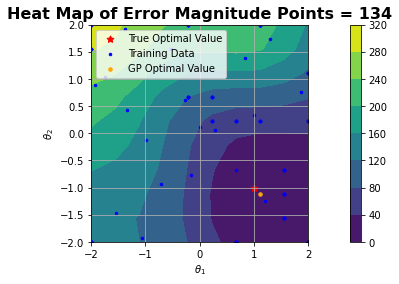

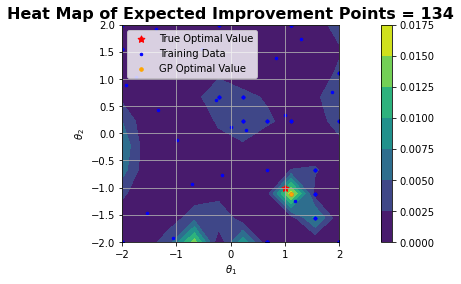

Final number of iterations:  23
The GP predicts that Theta = [ 1.11111111 -1.11111111]
The GP estimates the highest EI is at Theta =  [ 1.11111111 -1.11111111]


In [5]:
#Set number of training iterations and train GP
iterations = 1000
BO_iters = 30
for i in range(BO_iters):
    if torch.is_tensor(train_p) != True:
        train_p = torch.from_numpy(train_p)
    if torch.is_tensor(train_y) != True:
        train_y = torch.from_numpy(train_y)
    
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    # We will use the simplest form of GP model, exact inference
    #Defines our model in terms of the class parameters in bo_functions
    model = ExactGPModel(train_p, train_y, likelihood)
    
    train_GP = train_GP_model(model,likelihood, train_p, train_y, iterations, verbose=False)
    noise_list = train_GP[0]
    lengthscale_list = train_GP[1]
    outputscale_list = train_GP[2]
    
#     #Plot hyperparameters vs iteration
#     noise_title = "Noise Hyperparameter"
#     lengthscale_title = "Lengthscale Hyperparameter"
#     outputscale_title = "Outputscale Hyperparameter"
#     plot_hyperparams(iterations, noise_list,noise_title)
#     plot_hyperparams(iterations, lengthscale_list,lengthscale_title)
#     plot_hyperparams(iterations, outputscale_list,outputscale_title)
    
    outputscale = torch.tensor([1])
    lengthscale = torch.tensor([1])
    noise = torch.tensor([1])

    model.likelihood.noise = noise
    model.covar_module.base_kernel.lengthscale =lengthscale
    model.covar_module.outputscale = outputscale
    
#     print("Noise Hyperparameter: ", float(model.likelihood.noise))
#     print("Lengthscale Hyperparameter: ", float(model.covar_module.base_kernel.lengthscale))
#     print("Outputscale Hyperparameter: ", float(model.covar_module.outputscale))
    
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval();
    
    #Will compare the rigorous solution and approximation later (multidimensional integral over each experiment using a sparse grid)
    #Calculate EI
    EI_Components = eval_GP_components(p,n,Xexp,Yexp, theta_mesh, model, likelihood)
    EI = EI_Components[0]
    Error =EI_Components[1]
    y_GP = EI_Components[2]
    stdev_GP = EI_Components[3]
    error_GP = EI_Components[4]
#     print(Error)

    #Finds the index where sse is the smallest and finds which Theta combination corresponds to that value
    argmin = np.array(np.where(np.isclose(Error, np.amin(Error),atol=1e-10)==True))
    Theta_1_Opt = float(theta1_mesh[argmin[0],argmin[1]])
    Theta_2_Opt = float(theta2_mesh[argmin[0],argmin[1]])
    Theta_Opt_GP = np.array((Theta_1_Opt,Theta_2_Opt))


    #calculates best theta value
    argmax = np.array(np.where(np.isclose(EI, np.amax(EI),atol=1e-10)==True))
    #     print(argmax)
    Theta1_Best = float(theta1_mesh[argmax[0],argmax[1]])
    Theta2_Best = float(theta2_mesh[argmax[0],argmax[1]])
    Theta_Best = np.array((Theta1_Best,Theta2_Best))
    
    
    ##If statement to show convergence
    Converge = np.allclose(Theta_Best, train_p[-1,0:2],atol=1e-10)
    if Converge == True:
        error_plotter(theta_mesh, Error, Theta_True, Theta_Opt_GP,train_p,plot_train=True)
        ei_plotter(theta_mesh, EI, Theta_True, Theta_Opt_GP,train_p,plot_train=True)
        print("Final number of iterations: ", i)
        print("The GP predicts that Theta =",Theta_Opt_GP)
        print("The GP estimates the highest EI is at Theta = ",Theta_Best)
        break
    
#     ei_plotter(theta_mesh, EI, Theta_True, Theta_Opt_GP,train_p,plot_train=True)
    print("The GP predicts that Theta =",Theta_Opt_GP, " at iteration ", i)
#     print("The GP estimates the highest EI is at Theta = ",Theta_Best, " at iteration ", i, "\n")

    ##Append best values to training data 
    #Convert training data to numpy arrays to allow concatenation to work
    train_p = train_p.numpy() #(q x t)
    train_y = train_y.numpy() #(1 x t)
    
    #Loops over Xexp values
    for i in range(n):
#         print(train_y)
        ##Calculate y_Best and formal p_Best
        #Add 5 test points, same Theta1 and Theta2, but use all values of Xexp
        p_Best = np.array([Theta_Best[0],Theta_Best[1],Xexp[i]]) #(q x 1)
#         print(p_Best)
        y_Best = create_y_data(q,p_Best) #(1 x 1)
        
        #Add Theta_Best to train_p and y_best to train_y
        train_p = np.concatenate((train_p, [p_Best]), axis=0) #(q x t)
        train_y = np.concatenate((train_y, [y_Best]),axis=0) #(1 x t)




In [6]:
mesh_3D = np.meshgrid(Theta1,Theta2,Xexp)

In [7]:
# EI_sing = calc_ei_total_test(p,n,Xexp,Yexp, theta_mesh, model, likelihood)[0]
# Error =calc_ei_total_test(p,n,Xexp,Yexp, theta_mesh, model, likelihood)[1]
# for i in range(n):    
#     ei_plotter_adv_test(theta_mesh, EI_sing[i], Theta_True, train_p,Xexp[i],Theta_Opt_GP,plot_train=True)

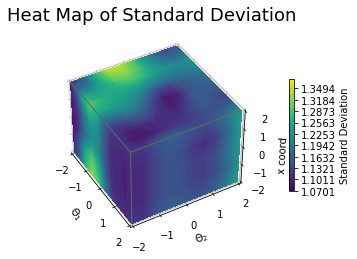

In [8]:
stdev_plot = stdev_plotter_4D(mesh_3D,stdev_GP)

## Analysis of Standard Deviation
 - The GP estimates that the standard deviation is lowest at points that were directly tested
  - This can be rationalized by the way that the contour plot is drawn
 - Standard deviation is smallest away from the edges and larger towards them
  - This is rationalized by the fact that there are less neighbors that the GP is tested and trained with at the boundaries
 - The more points that get tested, the more the standard deviations will decrease

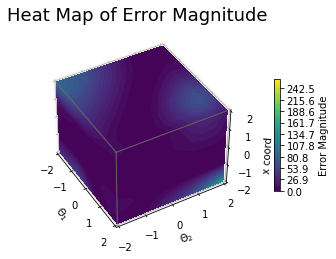

In [9]:
error_plot = error_plotter_4D(mesh_3D,error_GP)

## Analysis of Error Magnitude
 - The GP emulator is most inaccurate when all values of $\bar{p}$ are at their extreme points 
  - In general, the GP is less accurate at extreme points, this is rationalized by the fact that there are less neighbors that the GP is tested and trained with at the boundaries
 - The GP emulator is most accurate after convergence
 - GP error is mostly very low, as more iterations are added, error decreases

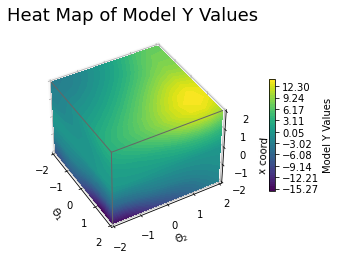

14.139167407882553
-15.88220517281292


In [15]:
y_plot = y_plotter_4D(mesh_3D,y_GP)
print(np.amax(y_GP))
print(np.amin(y_GP))

## Analysis of GP Emulator (Model y)
 - The GP emulator correctly captures that y increases as $\bar{p}$ increases. This tells us that this GP emulator model could be viable
  - The GP emulator suitably estimates where the lowest y is achieved and the actual value of y
  - Slight error leads to small inaccuracies in the value of $\bar{\theta}$ and the values of y